In [1]:
from pathlib import Path
import sys
 
if sys.argv:
    sys.path.insert(0, str(Path('/Users/ogrobertino/UpliftModelingResearch/').resolve()))
%load_ext autoreload
%autoreload 2
import pandas as pd
from src.datasets import sample_features, TorchDataset, NumpyDataset
from src.global_params import * 

In [2]:
import json
import os
import pickle
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.tlearner as tlearner
import causalml.inference.meta.slearner as slearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.xlearner as xlearner
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier


class IModelUplift(ABC):
    """
    Интерфейс для реализации моделей uplift.
    """

    def __init__(self, config_json):
        """
        Конструктор, принимающий конфигурацию в формате JSON.
        """
        if isinstance(config, dict) == True:
            self.config = config_json
        else:
            with open(config_json, 'r',) as fh:
                data = json.load(fh)
            self.config = data

    @abstractmethod
    def fit(self, X, y):
        """
        Метод для обучения модели.
        """
        pass

    @abstractmethod
    def predict(self, X):
        """
        Метод для предсказания.
        """
        pass

    @abstractmethod
    def save(self, path):
        """
        Метод для сохранения обученной модели в файл.
        """
        pass

    @classmethod
    @abstractmethod
    def load(cls, path):
        """
        Метод для загрузки обученной модели из файла.
        """
        pass

class ICausalML(IModelUplift):
    def __init__(self, config_json):
        super().__init__(config_json)

    def fit(self, train):
        self.model.fit(
            X=train.data.loc[:, train.cols_features].values,
            treatment=train.data.loc[:, train.col_treatment].values,
            y=train.data.loc[:, train.col_target].values,
        )

    def predict(self, X):
        scores = X.data.copy(deep=True)
        scores['score'] = self.model.predict(scores.loc[:, X.cols_features])
        return scores[['score', X.col_treatment, X.col_target]]

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {path}.")

    @classmethod
    def load(cls, path):
        if not os.path.exists(path):
            raise ValueError(f"No model file found at '{path}'.")
        
        with open(path, 'rb') as f:
            loaded_model = pickle.load(f)
        print(f"Model loaded from {path}.")

        self.model = loaded_model

# Конкретная реализация модели
class TModel(ICausalML):
    """
    t-моделинг с помощью causalml.
    """

    def __init__(self, config_json):
        super().__init__(config_json)
        self.model = tlearner.BaseTClassifier(
            control_learner=CatBoostClassifier(verbose=0, **self.config['lvl_1']['control']),
            treatment_learner=CatBoostClassifier(verbose=0, **self.config['lvl_1']['treatment']),
            **self.config['lvl_0']['meta']
        )

def ModelUpliftFactory(config_json, model_class):
    """
    Фабрика для создания экземпляра модели uplift.

    :param config_json: JSON-строка с конфигурацией модели.
    :param model_class: Класс, реализующий интерфейс ModelUplift.
    """
    if not issubclass(model_class, ModelUplift):
        raise ValueError("model_class должен быть подклассом ModelUplift.")
    
    return model_class(config_json)

class IFactory(ABC):
    @staticmethod
    @abstractmethod
    def create():
        """Фабричный метод, создающий объект модели и датасета."""
        pass

class TModelFactory(IFactory):
    @staticmethod
    def create(config_json, train_path, test_path):
        model = TModel(config_json)
        train = NumpyDataset(train_path)
        test = NumpyDataset(test_path)
        return model, train, test

Failed to import duecredit due to No module named 'duecredit'


In [3]:
# model, train, test = TModelFactory.create(config, path_train, path_test)
# model.fit(train)
# predicted = model.predict(test)

In [4]:
# cmetrics.auuc_score(
#     predicted, 
#     outcome_col=col_target, 
#     treatment_col=col_treatment, 
# )

In [5]:
# ml_auuc, random_auuc = cmetrics.auuc_score(
#     predicted, 
#     outcome_col=col_target, 
#     treatment_col=col_treatment, 
# )

In [6]:
# cmetrics.plot_gain(
#     predicted,
#     treatment_col=col_treatment,
#     outcome_col=col_target,
# )

In [7]:
def get_paths_train_test(ds_name, features_percent):

    path_to_data_train = f'../data/{ds_name}/{features_percent}/train.tsv'
    path_to_data_test = f'../data/{ds_name}/{features_percent}/test.tsv'

    return path_to_data_train, path_to_data_test

In [8]:
#TODO outpath
def train_test_model(ds_name, features_percent, factory, config):
    train_path, test_path = get_paths_train_test(ds_name=ds_name, features_percent=features_percent)
    model, train, test = factory.create(config, train_path, test_path)
    model.fit(train)
    predicted = model.predict(test)
    ml_auuc, random_auuc = cmetrics.auuc_score(
        predicted, 
        outcome_col=col_target, 
        treatment_col=col_treatment, 
    )

    print(ml_auuc, random_auuc)
    cmetrics.plot_gain(
        predicted,
        treatment_col=col_treatment,
        outcome_col=col_target,
    )
    
    

In [9]:
config = \
{
  "lvl_0": {
    "meta": {
      "control_name": 0
    }
  },
  "lvl_1": {
    "treatment": {
      "iterations": 20,
      "learning_rate": 0.1,
      "depth": 6,
      "loss_function": "Logloss",
      "eval_metric": "AUC"
    },
    "control": {
      "iterations": 30,
      "learning_rate": 0.05,
      "depth": 4,
      "loss_function": "Logloss",
      "eval_metric": "AUC"
    }
  }
}

In [10]:
train_path, test_path = get_paths_train_test(ds_name='lazada', features_percent=100)

0.7192712115518879 0.49519159207407876


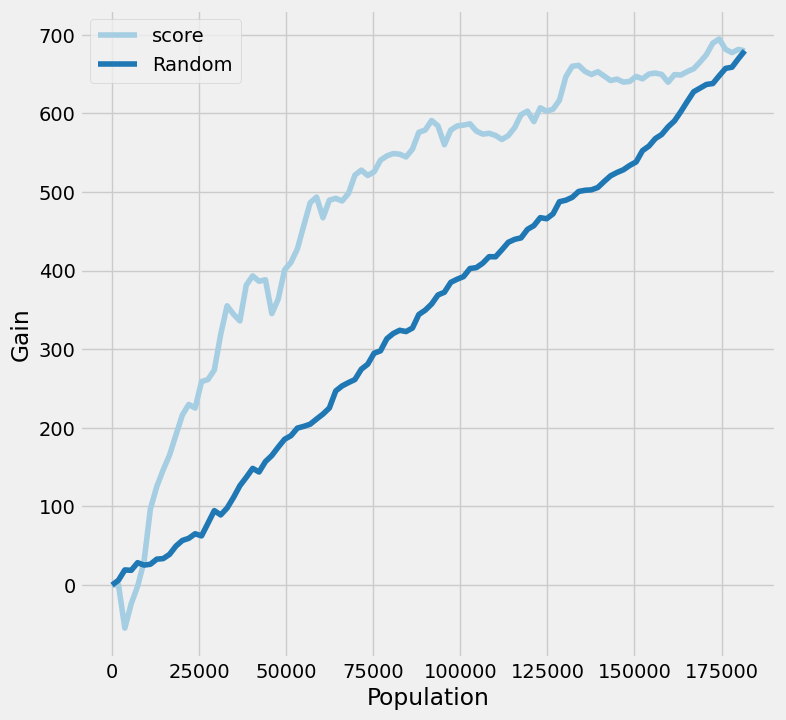

In [11]:
train_test_model(ds_name='lazada', features_percent=100, factory=TModelFactory, config=config)